# Visualize

In [1]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from GetModel import GetModel

In [2]:
# Computes mean of activation maps tensor
def mean_activations(tensor):
    # squeeze to remove batch dimension
    return torch.mean(tensor.detach().cpu(), dim=1).squeeze(dim=0)

# Computes saliency map
def get_saliency(output, image, num_views, side=0):
    out = torch.sigmoid(output)
    out = out.view(-1)[side] if num_views == 4 else out
    out.backward()
    saliency, _ = torch.max(image.grad.data.abs(), dim=1)   
    # squeeze to remove batch dimension
    return saliency.cpu().squeeze(dim=0)

Images/views should have the following shape:

- 2 views: `(2*600, 500)`
- 4 views: `(4*600, 500)`

In other words the views are stacked together along the first dimension.

In [3]:
# Example images
IMG_PATH_2VIEWS = "Example_images/CBIS/P_00001_LEFT.png"
IMG_PATH_4VIEWS = "Example_images/INbreast/f4b2d377f43ba0bd.png"

## 2 views

In [4]:
def get_maps_2views(model, weights, image):
    net = GetModel(str_model=model, n=2, num_classes=1, visualize=True)
    net.add_top_blocks(num_classes=1)
    net.load_state_dict(torch.load(weights, map_location='cpu'))
    net = net.to('cpu')
    net.eval()
    
    image = torch.from_numpy(image)
    image = image.unsqueeze(0) # Add batch dimension
    image = image.requires_grad_() # To compute saliency map
    
    result = dict()
    
    out, out_before_refiner, out_refiner = net(image)
    result['mean_out_before_refiner'] = mean_activations(out_before_refiner)
    result['mean_out_refiner'] = mean_activations(out_refiner)  
    result['saliency'] = get_saliency(out, image, num_views=2)     
    return result

def visualize_2views(img_path, model, weights):
    image = np.array(Image.open(img_path))/257
    image = np.reshape(image, (2, image.shape[0]//2, image.shape[1]))

    plt.rcParams.update({'font.size': 26})
    fig, axes = plt.subplots(1, 5, figsize=(26, 16))
    for i in range(5):
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    axes[0].set_xlabel('CC')
    axes[1].set_xlabel('MLO')
    axes[2].set_xlabel('Saliency map')
    axes[3].set_xlabel('Act. map - Before Ref.')
    axes[4].set_xlabel('Act. map - Refiner')
    
    axes[0].imshow(image[0], cmap='gray')
    axes[1].imshow(image[1], cmap='gray')
    
    res = get_maps_2views(model=model, weights=weights, image=image)    
    axes[2].imshow(res['saliency'], cmap="gnuplot")
    axes[3].imshow(res['mean_out_before_refiner'], cmap="gnuplot")
    axes[4].imshow(res['mean_out_refiner'], cmap="gnuplot")

Model: phcresnet18



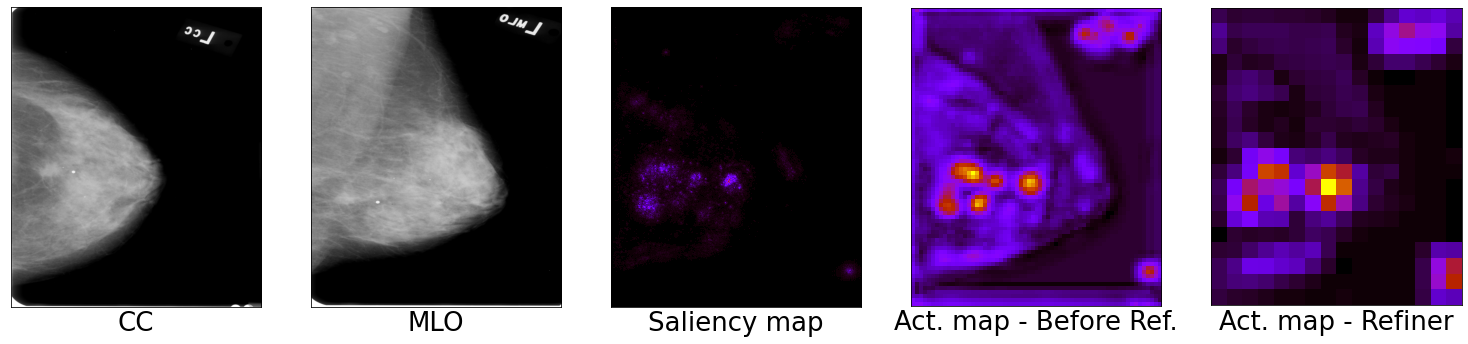

In [5]:
MODEL = 'phcresnet18'
WEIGHTS = 'weights/phresnet18_cbis2views.pt'
visualize_2views(img_path=IMG_PATH_2VIEWS, model=MODEL, weights=WEIGHTS)

## 4 views

In [6]:
def get_maps_4views(model, weights, image, side, visualize):
    net = GetModel(str_model=model, n=2, num_classes=1, weights=None, visualize=visualize)
    net.load_state_dict(torch.load(weights, map_location='cpu'))
    net = net.to('cpu')
    net.eval()
    
    image = torch.from_numpy(image)
    image = image.unsqueeze(0) # Add batch dimension
    image = image.requires_grad_() # To compute saliency map
    input = torch.split(image, split_size_or_sections=2, dim=1)
    
    result = dict()
    
    if visualize:
        out, out_enc_sx, out_enc_dx, out_cl_sx, out_cl_dx = net(input)
    
        result['mean_enc_sx'] = mean_activations(out_enc_sx)
        result['mean_enc_dx'] = mean_activations(out_enc_dx)
        result['mean_cl_sx'] = mean_activations(out_cl_sx)
        result['mean_cl_dx'] = mean_activations(out_cl_dx)
        
    else:
        out = net(input)
    
    result['saliency'] = get_saliency(out, image, num_views=4, side=side)  
    return result
    

def visualize_4views(img_path, model, weights):
    image = np.array(Image.open(img_path))/257
    image = np.reshape(image, (4, image.shape[0]//4, image.shape[1]))

    plt.rcParams.update({'font.size': 26})
    fig, axes = plt.subplots(2, 5, figsize=(26, 16))
    for i in range(2):
        for j in range(5):
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

    axes[0, 0].set_ylabel('Left')
    axes[1, 0].set_ylabel('Right')
    axes[1, 0].set_xlabel('CC')
    axes[1, 1].set_xlabel('MLO')
    axes[1, 2].set_xlabel('Saliency map')
    axes[1, 3].set_xlabel('Act. map - Encoder')
    axes[1, 4].set_xlabel('Act. map - Classifier')
    
    axes[0, 0].imshow(image[0], cmap='gray')
    axes[0, 1].imshow(image[1], cmap='gray')
    axes[1, 0].imshow(image[2], cmap='gray')
    axes[1, 1].imshow(image[3], cmap='gray')
    
    res_0 = get_maps_4views(model=model, weights=weights, image=image, side=0, visualize=False)
    res_1 = get_maps_4views(model=model, weights=weights, image=image, side=1, visualize=True)
    
    axes[0, 2].imshow(res_0['saliency'], cmap="gnuplot")
    axes[1, 2].imshow(res_1['saliency'], cmap="gnuplot")
    axes[0, 3].imshow(res_1['mean_enc_sx'], cmap="gnuplot")
    axes[1, 3].imshow(res_1['mean_enc_dx'], cmap="gnuplot")
    axes[0, 4].imshow(res_1['mean_cl_sx'], cmap="gnuplot")
    axes[1, 4].imshow(res_1['mean_cl_dx'], cmap="gnuplot")

Model: physenet

Model: physenet



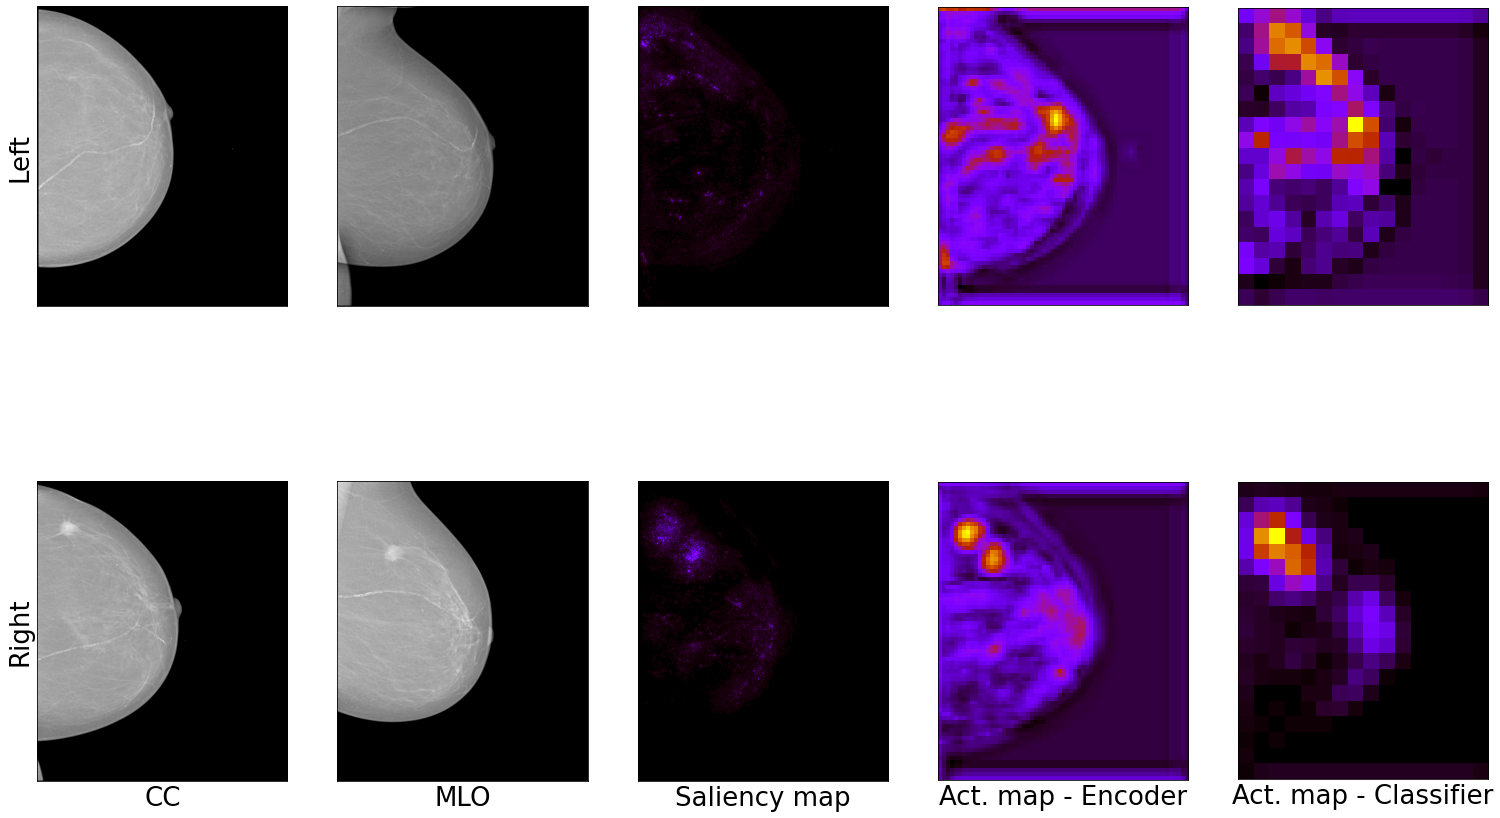

In [7]:
MODEL = 'physenet'
WEIGHTS = 'weights/physenet_inbreast4views_patches_pretr.pt'
visualize_4views(img_path=IMG_PATH_4VIEWS, model=MODEL, weights=WEIGHTS)